In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pykitti
from vo_funcs import VisualOdometry
from tqdm import tqdm
data_dir = './' 
date = '2011_09_26'
drive = '0001'
data = pykitti.raw(data_dir, date, drive)

ModuleNotFoundError: No module named 'vo_funcs'

In [ ]:
data.oxts[2].packet.ve

-11.221558050195

In [ ]:
for i in range(10):
    print("pos", data.oxts[i].packet.pos_accuracy)
    print("vel", data.oxts[i].packet.vel_accuracy)

pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358
pos 0.027658633371879
vel 0.012727922061358


In [ ]:
vo = VisualOdometry(data_dir, date, drive)
for i, gt_pose in enumerate(tqdm(vo.gt_poses[:10], unit="poses")):
    if i < 1:
        cur_pose = gt_pose
    else:
        transf = vo.get_pose(i)
        cur_pose = np.matmul(cur_pose, transf)
    
    print("VO:", -cur_pose[:3, 3])
    print("GT:", gt_pose[:3,3])
    print()


In [ ]:
2**13

8192

In [ ]:
vo = VisualOdometry(data_dir, date, drive)
_, t_start = pykitti.utils.pose_from_oxts_packet(data.oxts[0].packet, scale=1)
cutout_region = [i for i in range(9,20)]
def getMeasurement(index, H):
    _, t = pykitti.utils.pose_from_oxts_packet(data.oxts[index].packet, scale=1)
    t -=t_start
    x = t[0]
    y = t[1]
    x_vel = data.oxts[index].packet.ve
    y_vel = data.oxts[index].packet.vn
    pos_uncertainty = data.oxts[index].packet.pos_accuracy
    vel_uncertainty = data.oxts[index].packet.vel_accuracy

    R = np.array([
        [pos_uncertainty, 0],
        [0, vel_uncertainty]
    ])
    if index in cutout_region:
        x = 14
        R = np.array([ 
            [2**x, 0],
            [0, 2**x]
        ])
        return H @ np.array([x*10*np.random.normal(0), x_vel*10*np.random.normal(0)]), R
    return H @ np.array([x, x_vel]), R
Tr = vo.dataset.calib.T_cam0_imu.round(4)

def getGT(index):
    R, t = pykitti.utils.pose_from_oxts_packet(data.oxts[index].packet, scale=1)
    t -=t_start
    return t[0]
def predict(A, X_vec, B, u, P, Q):
    predicted_X = A @ X_vec + B @ u
    predicted_P = A @ P @ A.T + Q
    return predicted_X, predicted_P
def calc_gain(P, H, R):
    numerator = P@H.T
    denominator = H@P@H.T + R
    K = numerator/denominator
    print(K)
    K[0,1] = 0
    K[1,0] = 0
    return K
def update(X_vec, K, z, H, P):
    print(K)
    updated_X = X_vec + K @ (z - H@X_vec)
    n = len(K@H)
    updated_P = (np.eye(n)-K@H)@P
    return updated_X, updated_P

In [ ]:
dt = 0.1
A = np.array([
    [1, 0],
    [0, 0]
])
B = np.array([ 
    [0,dt],
    [0,1]
])
P = np.array([
    [10, 0],
    [0, 10]
])
Q = np.array([
    [1, 0],
    [0, 3]
])
H = np.array([
    [1, 0],
    [0, 1]
])

In [ ]:
X_vec = np.array([0,0])
positions = []
gt_positions = []
vo = VisualOdometry(data_dir, date, drive)
for i, gt_pose in enumerate(vo.gt_poses[:40]):
    if i < 1:
        cur_pose = gt_pose
        delta_x = -cur_pose[2, 3]
    else:
        transf = vo.get_pose(i)
        old_pose = np.copy(cur_pose)
        cur_pose = np.matmul(cur_pose, transf)
        delta_x = -cur_pose[2, 3] - (-old_pose[2,3])
    x_vo_velocity = delta_x/dt
    u = np.array([ 
        0,
        x_vo_velocity
    ])
    print("Iteration", i)
    predicted_X, predicted_P = predict(A, X_vec, B, u, P, Q)
    z, R = getMeasurement(i, H)
    K = calc_gain(predicted_P, H, R)

    print("z:", z, "predicted_X", predicted_X)

    X_vec, P = update(predicted_X, K, z, H, predicted_P)

    print("Update_x:", X_vec, "GT:", getGT(i))
    
    positions.append(X_vec[0])
    gt_positions.append(getGT(i))
    
# print(positions)
# print(gt_positions)

Iteration 0
[[0.99749189        nan]
 [       nan 0.99577528]]
z: [  0.         -11.27564181] predicted_X [0. 0.]
[[0.99749189 0.        ]
 [0.         0.99577528]]
Update_x: [  0.         -11.22800542] GT: 0.0


C:\Users\Bhargav\AppData\Local\Temp\ipykernel_15064\1346913569.py:39: RuntimeWarning: invalid value encountered in true_divide
  K = numerator/denominator


Iteration 1
[[0.97378944        nan]
 [       nan 0.99577528]]
z: [ -1.88528864 -11.25071862] predicted_X [ -1.40801554 -14.08015537]
[[0.97378944 0.        ]
 [0.         0.99577528]]
Update_x: [ -1.87277905 -11.26267219] GT: -1.8852886399254203
Iteration 2
[[0.97377315        nan]
 [       nan 0.99577528]]
z: [ -3.59410719 -11.22155805] predicted_X [ -3.26228691 -13.89507868]
[[0.97377315 0.        ]
 [0.         0.99577528]]
Update_x: [ -3.58540459 -11.23285292] GT: -3.5941071885172278
Iteration 3
[[0.97377314        nan]
 [       nan 0.99577528]]
z: [ -5.29982794 -11.19874288] predicted_X [ -4.99851803 -14.13113445]
[[0.97377314 0.        ]
 [0.         0.99577528]]
Update_x: [ -5.29192553 -11.21113141] GT: -5.299827938317321
Iteration 4
[[0.97377314        nan]
 [       nan 0.99577528]]
z: [ -7.17162742 -11.17529452] predicted_X [ -6.661309   -13.69383472]
[[0.97377314 0.        ]
 [0.         0.99577528]]
Update_x: [ -7.15824337 -11.18593464] GT: -7.171627416391857
Iteration 5
[[

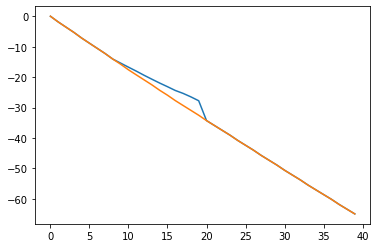

In [ ]:
plt.plot(positions)
plt.plot(gt_positions)
plt.show()

In [ ]:
def filter(z, updateNumber):
    dt = 0.1
    # Initialize State
    if updateNumber == 1:
        filter.x = np.array([[0],
                            [20]])
        filter.P = np.array([[5, 0],
                                 [0, 5]])

        filter.A = np.array([[1, dt],
                             [0, 1]])
        filter.H = np.array([[1, 0]])
        filter.HT = np.array([[1],
                              [0]])
        filter.R = 10
        filter.Q = np.array([[1, 0],
                             [0, 3]])

    # Predict State Forward
    x_p = filter.A.dot(filter.x)
    # Predict Covariance Forward
    P_p = filter.A.dot(filter.P).dot(filter.A.T) + filter.Q
    # Compute Kalman Gain
    S = filter.H.dot(P_p).dot(filter.HT) + filter.R
    K = P_p.dot(filter.HT)*(1/S)

    # Estimate State
    residual = z - filter.H.dot(x_p)
    filter.x = x_p + K*residual

    # Estimate Covariance
    filter.P = P_p - K.dot(filter.H).dot(P_p)

    return [filter.x[0], filter.x[1], filter.P];

In [ ]:
def testFilter():
    dt = 0.1
    t = np.linspace(0, 10, num=300)
    numOfMeasurements = len(t)

    measTime = []
    measPos = []
    measDifPos = []
    estDifPos = []
    estPos = []
    estVel = []
    posBound3Sigma = []

    for k in range(1,numOfMeasurements):
        z = getMeasurement(k)
        # Call Filter and return new State
        f = filter(z[0], k)
        # Save off that state so that it could be plotted
        measTime.append(k)
        measPos.append(z[0])
        measDifPos.append(z[0]-z[1])
        estDifPos.append(f[0]-z[1])
        estPos.append(f[0])
        estVel.append(f[1])
        posVar = f[2]
        posBound3Sigma.append(3*np.sqrt(posVar[0][0]))

    return [measTime, measPos, estPos, estVel, measDifPos, estDifPos, posBound3Sigma];

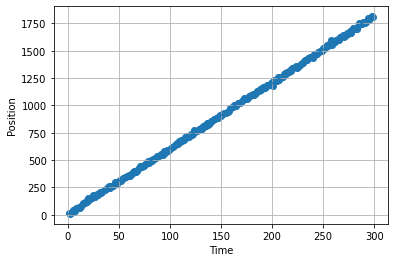

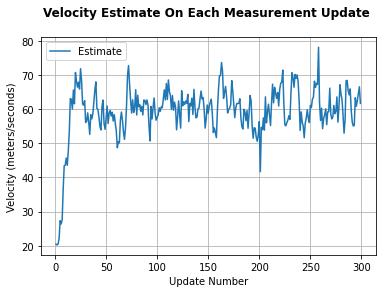

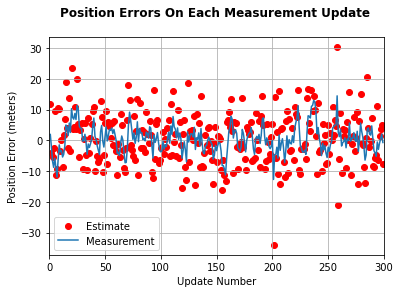

In [ ]:
t = testFilter()

plot1 = plt.figure(1)
plt.scatter(t[0], t[1])
plt.plot(t[0], t[2])
plt.ylabel('Position')
plt.xlabel('Time')
plt.grid(True)

plot2 = plt.figure(2)
plt.plot(t[0], t[3])
plt.ylabel('Velocity (meters/seconds)')
plt.xlabel('Update Number')
plt.title('Velocity Estimate On Each Measurement Update \n', fontweight="bold")
plt.legend(['Estimate'])
plt.grid(True)

plot3 = plt.figure(3)
plt.scatter(t[0], t[4], color = 'red')
plt.plot(t[0], t[5])
plt.legend(['Estimate', 'Measurement'])
plt.title('Position Errors On Each Measurement Update \n', fontweight="bold")
#plt.plot(t[0], t[6])
plt.ylabel('Position Error (meters)')
plt.xlabel('Update Number')
plt.grid(True)
plt.xlim([0, 300])
plt.show()